In [34]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.affinity import scale
from shapely.geometry import Point, Polygon
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import DataFrame as DF
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from peakutils import baseline
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression  # noqa: E402
from sklearn.ensemble import (  # noqa: E402
    ExtraTreesRegressor,  # noqa: E402
)
from scipy.signal import savgol_filter
from pyspectra.transformers.spectral_correction import snv, detrend
import funcy
import random
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from caching import cached





#   plot principial components
#  take subset in the PC space of US data
# impact of variety of the data (stratification) on learning curves. Do we need less samples as long as they are diverse enough?


import seaborn as sns


sns.set(rc={'figure.figsize':(11.7,8.27)})


def assert_unreachable(x):
    raise AssertionError(f"Entered a code path that should not be reachable, argument value: {x!r}")

def normalize(df):
    return (df - df.mean()) / df.std()

def unskew(s, threshold=1.5):
    eps = 1e-5
    while skew(s) >= threshold:
        s = s - min(s)
        s = np.log(1 + s)
    return s

def detect_outliers(df_or_s, method="quantile", quantile=0.97, std_mult=3):
    if method == "quantile":
        upper = df_or_s.quantile(quantile)
        lower = df_or_s.quantile(1 - quantile)
        outliers = (df_or_s >= upper) | (df_or_s <= lower)
    elif method == "std":
        outliers = (df_or_s - df_or_s.mean()).abs() >= std_mult * df_or_s.std()
    else:
        assert_unreachable(method)
    return outliers

def drop_outliers(df_or_s, method="quantile",quantile=0.97, std_mult=3):
    df_or_s = df_or_s.copy()
    len_before = len(df_or_s.index)
    outliers = detect_outliers(df_or_s, method, quantile, std_mult)
    if isinstance(df_or_s, DF):
        outliers = outliers.any(axis=1)
    df_or_s = df_or_s[~outliers]
    len_after = len(df_or_s.index)
    print(f"dropped {len_before - len_after} rows")
    return df_or_s


def clean_wcdf(wcdf_raw):
    wcdf_values = wcdf_raw.iloc[:,1:]
    wcdf_unskewed = wcdf_values.apply(unskew)
    wcdf_norm = normalize(wcdf_unskewed)
    wcdf = drop_outliers(wcdf_norm, method="quantile", quantile=0.99)
    return wcdf


def get_clean_wcdf():
    wcdf_raw = pd.read_csv('../sis_dataset/sis_dataset/wetchem.csv')
    return clean_wcdf(wcdf_raw)

SEED = 667788
N_JOBS = 1

In [2]:
def keep_newest_version(dry):
    dry = dry.sort_values('version', ascending=False).drop_duplicates("id")
    dry = dry.sort_values('id')
    dry = dry.drop(columns=["version"])
    return dry






def drop_zero_absorbance(vs):
    outliers = (vs < 0.5).all(axis=1)
    return vs[~outliers]

def remove_baseline(vs) -> np.ndarray:
    base = np.apply_along_axis(lambda x: baseline(x, 2), 0, vs)
    base = np.mean(base, axis=0)
    vs = vs - base
    return vs

def gradients(x: np.ndarray) -> np.ndarray:
    return np.apply_along_axis(np.gradient, 1, x)

def smoothing(x: np.ndarray, window_size=51, order=3) -> np.ndarray:
    return savgol_filter(x, window_size, order, axis=1)

def remove_CO2_freqs(df: DF) -> DF:
    freqs = df.columns.astype(float)
    retain = (freqs <= 2268) | (freqs >= 2389)
    return df[df.columns[retain]]

def snv(df):
    eps = 1e-6
    return (df - df.mean()) / (df.std() + eps)



In [35]:

def get_raw_sis():
    wet_sis_raw = pd.read_csv('../sis_dataset/sis_dataset/wetchem.csv')
    dry_sis_raw = pd.read_csv('../sis_dataset/drychem.csv')
    dry_sis = keep_newest_version(dry_sis_raw)
    return wet_sis_raw.set_index("id").join(dry_sis.set_index("id"), how="inner").reset_index()

def spec_cols_mask(df):
    mask = df.columns.str.match("[0-9]+\.[0-9]+")
    return mask

def spec_cols(df):
    return df.iloc[:, spec_cols_mask(df)]


def transform_specs(df, f):
    df = df.copy()
    x = spec_cols(df)
    x_transformed = DF(f(x), columns=df.columns[spec_cols_mask(df)])
    return pd.concat([df.loc[:, ~spec_cols_mask(df)], x_transformed], axis=1)


def get_model_data(df, analyte, stratify=None):
    train, test = train_test_split(df, test_size=0.2, stratify=stratify, random_state=SEED)
    X_train, y_train = spec_cols(train), train[analyte]
    X_test, y_test = spec_cols(test), test[analyte]
    return (X_train, y_train, X_test, y_test)

@cached("score_model")
def score_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

@cached("get_clean_sis")
def get_clean_sis(transforms=(smoothing, gradients, remove_baseline)):
    df = get_raw_sis()
    transform = funcy.compose(*transforms)
    df = transform_specs(df, transform)
    return df
    
xtrees_factory = lambda: ExtraTreesRegressor(n_jobs=N_JOBS, random_state=SEED)




In [4]:
sis = get_clean_sis()

In [18]:
sis_data = get_model_data(sis, "pH")
model = xtrees_factory()
score_model(model, *sis_data)

0.7077286199388744

In [213]:
def clip_outliers(x, lower=1, upper=99):
    l_perc = np.percentile(x, lower)
    u_perc = np.percentile(x, upper)
    return np.clip(x, l_perc, u_perc)


def identity(x):
    return x

def get_clipped_model(model):
    return TransformedTargetRegressor(
        regressor=model,
        func=clip_outliers,
        inverse_func=identity,
        check_inverse=False
    )

In [214]:
clipped_model = get_clipped_model(xtrees_factory())
score_model(clipped_model, *sis_data)

0.703428787618792

# Compare with USDA

In [19]:
usda_raw = pd.read_csv('usda_easy.csv')

In [20]:
@cached("get_clean_usda")
def get_clean_usda():
    return transform_specs(usda_raw, funcy.compose(smoothing, gradients, remove_baseline))


usda = get_clean_usda()

In [21]:
small_usda = usda.iloc[:50, :].sample(frac=1, random_state=SEED)

In [36]:
from functools import reduce

@cached("cv_score")
def cv_score(df, analyte, stratify=None, model_factory=xtrees_factory,random_state=SEED ):
    df = df.sample(frac=1, random_state=random_state) # random shuffle
    model = model_factory()
    X = spec_cols(df)
    y = df[analyte]
    if stratify:
        if isinstance(stratify, str) or isinstance(stratify, tuple):
            stratify = quantile_strat_f(stratify, n_strata=10)
        skf = StratifiedKFold(n_splits=5)
        stratify_col = stratify(df)
        cv = skf.split(X, stratify_col)
    else:
        cv = None
    return cross_val_score(model, X, y, scoring="r2", cv=cv, n_jobs=N_JOBS)



def quantile_strat_f(cols, n_strata=5):
    discretizer_f = lambda: KBinsDiscretizer(n_bins=n_strata, encode="ordinal", strategy="quantile")
    if isinstance(cols, str):
        cols = [cols]

    def strat_f(df):
        ys = [df[col] for col in cols]
        discretize_f = lambda y: discretizer_f().fit_transform(y.values.reshape(-1, 1)).flatten().astype(int)
        ys_discrete = list(map(discretize_f, ys))
        encode_f = lambda x, y: x + y * n_strata
        return reduce(encode_f, ys_discrete)

    return strat_f


    

In [26]:
cv_score(small_usda, "nitrogen", stratify=quantile_strat_f(("nitrogen", "nitrogen", "nitrogen"), n_strata=10)).mean()




0.519708782262704

In [89]:
cv_score(small_usda, "nitrogen").mean()

0.30469527367106664

In [13]:
nitrogen_data = get_model_data(usda, "nitrogen")
model = xtrees_factory()
score_model(model, *nitrogen_data)
model.feature_importances_

array([2.06512905e-05, 3.98269242e-05, 3.97909245e-05, ...,
       6.57855995e-05, 6.93932753e-05, 3.81347357e-05])

In [14]:
len(model.feature_importances_) == len(spec_cols(usda).columns)

True

In [15]:
analyte = "nitrogen"


def get_small_train_test(usda, train_size, analyte):
    np.random.seed(10051997)

    full_train, test = train_test_split(usda, test_size=0.2, random_state=SEED)
    _, small_train = train_test_split(full_train, test_size=train_size)
    X_train, y_train = spec_cols(small_train), small_train[analyte]
    X_test, y_test= spec_cols(test), test[analyte]
    return (X_train, y_train, X_test, y_test)




xtrees = ExtraTreesRegressor(n_jobs=8, random_state=SEED)

scores = []
for train_size in np.arange(0.1, 1, 0.2):
    usda_data = get_small_train_test(usda, train_size, analyte)
    score = score_model(xtrees, *usda_data)
    scores.append(score)

scores

[0.9302284354738286,
 0.9565367441284279,
 0.9629499105643379,
 0.9649826804169146,
 0.9670233713044358]

# Partition on clay content


In [31]:
clay_raw = pd.read_csv("usda_clay_water.csv")

@cached("get_clean_clay_df")
def get_clean_clay_df():
    return transform_specs(clay_raw, funcy.compose(smoothing, gradients, remove_baseline))

clay_df = get_clean_clay_df()


In [52]:
import pickle
import os
import pickle
from pandas import DataFrame as DF, Series as S
import os
from inspect import isfunction


class cached:
    def __init__(self, fun_name):
        self.fun_name = fun_name
        self.reset_hash()

    def update_hash(self, value):
        self.hash = hash(str(self.hash) + str(value))

    def reset_hash(self):
        self.hash = 0

    def serialize_arg(self, arg):
        if isinstance(arg, (list, tuple, set)):
            res = []
            for x in arg:
                res.append(self.serialize_arg(x))
            return "-".join(res)

        if isfunction(arg):
            arg = arg.__name__
            if arg == "<lambda>":
                raise ValueError("please pass named functions")

        self.update_hash(arg)
        if isinstance(arg, DF):
            return "df:shape:" + str(arg.shape)
        if isinstance(arg, S):
            return "series:len:" + str(len(arg))

        try:
            return str(arg)
        except:
            return str(hash(arg))

    def serialize_args(self, args):
        return "-".join(self.serialize_arg(arg) for arg in args)

    def serialize_kwargs(self, kwargs):
        return "-".join(k + ":" + self.serialize_arg(v) for k, v in kwargs.items())

    def __call__(self, fun):
        self.reset_hash()

        def cached_f(*args, **kwargs):
            self.reset_hash()
            f_hash = (
                self.serialize_args(args)
                + "#"
                + self.serialize_kwargs(kwargs)
                + "#"
                + str(self.hash)
            )
            path = os.path.join("cache", self.fun_name, f_hash)
            if os.path.exists(path):
                with open(path, "rb") as file:
                    return pickle.load(file)

            result = fun(*args, **kwargs)
            os.makedirs(os.path.join("cache", self.fun_name), exist_ok=True)
            with open(path, "wb") as file:
                pickle.dump(result, file)

            return result

        return cached_f

@cached("get_learning_curve")
def get_learning_curve(df, analyte, fracs, stratify=None, seeds=(SEED,)):
    # scores = []
    # for seed in seeds:
    #     df = df.sample(frac=1, random_state=seed)
    #     for frac in fracs:
    #         subset = df.iloc[:int(frac * len(df.index)), :]
    #         subset_scores = cv_score(subset, analyte, stratify=stratify, random_state=seed)
    #         for score in subset_scores:
    #             scores.append((frac, score))

    # result = DF(scores, columns=["frac", "score"])

    # return result
    return df


lc = get_learning_curve(clay_df.iloc[:1000,:], "nitrogen", [0.1, 0.2, 1], seeds=(SEED, SEED+1))


<AxesSubplot:xlabel='frac', ylabel='score'>

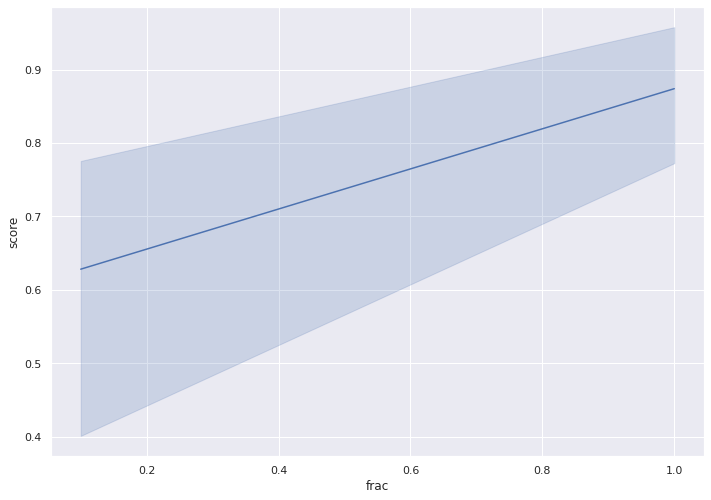

In [46]:
sns.lineplot(data=lc, x="frac", y="score")

<AxesSubplot:xlabel='frac', ylabel='score'>

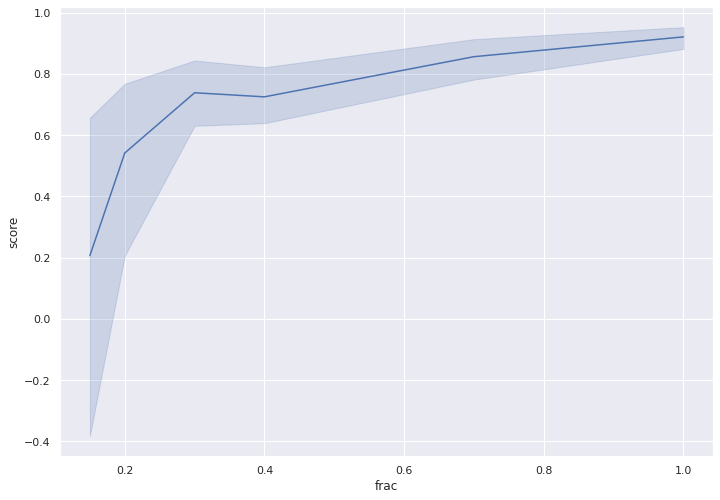

In [375]:
lc2 = get_learning_curve(clay_df.iloc[:1000,:], "nitrogen", [0.15, 0.2, 0.3, 0.4, 0.7, 1], stratify="clay", seeds=(SEED, SEED+1))
sns.lineplot(data=lc2, x="frac", y="score")

In [99]:
def plot_lc_comparison(df, analyte, fracs, strats, seeds=(SEED, SEED+1)):
    print(">"*len(strats))
    fig, ax = plt.subplots()
    for strat in strats:
        lc = get_learning_curve(df, analyte, fracs, strat, seeds) 
        sns.lineplot(data=lc, x="frac", y="score", ax=ax, label=str(strat))
        print("#", end="")
    plt.legend()

plot_lc_comparison(clay_df.iloc[:100, :], "nitrogen", [0.8, 1], [None, "nitrogen", "clay", "water"])

NameError: name 'clay_df' is not defined

In [342]:
cv_score(clay_df.iloc[:100,:], "nitrogen", stratify="clay").mean()

0.5226060954301104

In [343]:
cv_score(clay_df.iloc[:100,:], "nitrogen", stratify="nitrogen").mean()

0.14421394857649958

In [17]:

def score_partitioned_model(df, analyte, partition_on, threshold,model_factory=xtrees_factory):
    small_df, big_df = df[df[partition_on] <= threshold], df[df[partition_on] > threshold]
    small_data, big_data, all_data = get_model_data(small_df, analyte), get_model_data(big_df, analyte), get_model_data(df, analyte)
    for data, desc in zip([small_data, big_data], ["lower than", "higher than"]):
        score = score_model(model_factory(), *data)
        print(f'score for predicting {analyte} when {partition_on} is {desc} {threshold}: {score}')
    score = score_model(model_factory(), *all_data)
    print(f'score for predicting {analyte} on all data: {score}')


In [18]:
score_partitioned_model(clay_df, analyte="water", partition_on="clay", threshold=20)

score for predicting water when clay is lower than 20: 0.8455607467955377
score for predicting water when clay is higher than 20: 0.8868002505647471
score for predicting water on all data: 0.8802686403850206


# is this only because there is less data to train on?

In [19]:

def simulate_model_partitioning_sizes(df, analyte, partition_on, threshold, stratify_f=None, model_factory=xtrees_factory):
    low_size = (df[partition_on] <= threshold).sum()
    if stratify_f:
        stratify = stratify_f(df)
    else:
        stratify = None
    low_df, high_df = train_test_split(df, train_size=low_size, stratify=stratify, random_state=SEED)
    if stratify_f:
        high_st, low_st = stratify_f(high_df), stratify_f(low_df)
    else:
        high_st, low_st = None, None
    high_data, low_data = get_model_data(high_df, analyte, high_st), get_model_data(low_df, analyte, low_st)
    for data, desc in zip([high_data, low_data], ["lower than", "higher than"]):
        score = score_model(model_factory(), *data)
        print(f'score for predicting {analyte} when dataset sizes are the same '\
            f'as when partitioning according to {partition_on} being {desc} {threshold}: {score}')


In [20]:
simulate_model_partitioning_sizes(clay_df, analyte="water", partition_on="clay", threshold=20)

score for predicting water when dataset sizes are the same as when partitioning according to clay being lower than 20: 0.8863057932112053
score for predicting water when dataset sizes are the same as when partitioning according to clay being higher than 20: 0.8159365223408986


# How about perfect stratification?

In [21]:
def binary_threshold_stratify_f(analyte, threshold):
    def _stratify_f(df):
        return df[analyte] <= threshold
    return _stratify_f

    
np.random.seed(SEED) # why doesn't passing random state work?? (this works thank god)
random.seed(SEED)
simulate_model_partitioning_sizes(clay_df, analyte="water", partition_on="clay", threshold=20, stratify_f=binary_threshold_stratify_f("clay", 20))


score for predicting water when dataset sizes are the same as when partitioning according to clay being lower than 20: 0.902874940294456
score for predicting water when dataset sizes are the same as when partitioning according to clay being higher than 20: 0.793650777992023


# PCA small subset USDA

In [22]:
sis_dry_raw = pd.read_csv('../sis_dataset/drychem.csv')


# Deprecated

In [23]:
def interpolate(values, source_x, target_x):
    from scipy.interpolate import interp1d

    f = interp1d(source_x, values, kind="cubic", fill_value="extrapolate")
    return f(target_x)

usda_freqs = usda_raw.columns[6:].astype("float").values
sis_freqs =  sis_dry_raw.columns[2:].astype("float").values

common_freqs = usda_freqs[3:]

def interpolate_to_common(vs, source_freqs):
    return np.apply_along_axis(lambda x: interpolate(x, source_freqs, common_freqs), 1, vs)


In [24]:
usda_specs_interpolated = DF(interpolate_to_common(usda_raw.iloc[:, 6:].values, usda_freqs), columns=common_freqs)
usda_specs_interpolated["dataset"] = "usda"

In [25]:
sis_specs = sis_dry_raw[sis_dry_raw.version == 1].iloc[:, 2:]

sis_specs_interpolated = DF(interpolate_to_common(sis_specs.values, sis_freqs), columns=common_freqs)
sis_specs_interpolated["dataset"] = "sis"

In [26]:
def standard_transform(vs):
    vs = smoothing(vs)
    vs = gradients(vs)
    vs = remove_baseline(vs)
    return vs

all_specs = pd.concat([usda_specs_interpolated, sis_specs_interpolated])
all_specs.iloc[:, :-1] = standard_transform(all_specs.iloc[:, :-1])


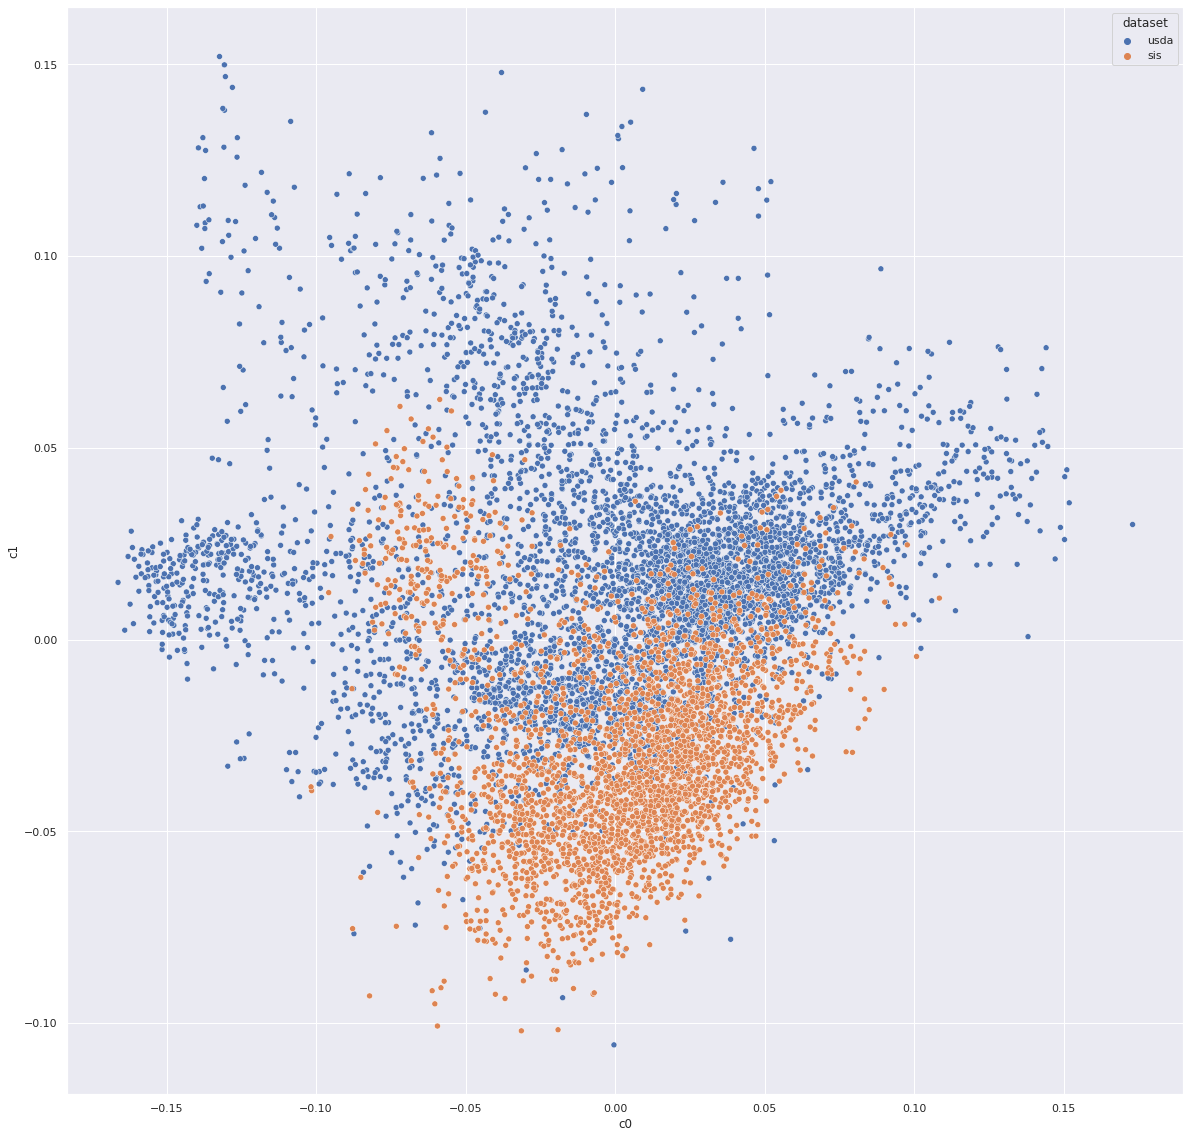

In [27]:


def do_reduction(reducer, specs):
    ds = specs['dataset']
    xs = specs.drop(columns='dataset')

    reduced_xs = reducer.fit_transform(xs)
    new_cols = [f'c{i}' for i in range(reducer.n_components)] + ['dataset']
    reduced_specs = pd.DataFrame(np.concatenate((reduced_xs, ds.values.reshape(-1, 1)), axis=1), columns=new_cols, index=specs.index)
    
    return reduced_specs    

def plot_reduction(specs, figsize=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize or (20, 20))
    sns.scatterplot(data=specs, x='c0', y='c1', hue='dataset', ax=ax)

pca = PCA(n_components=2)
reduced = do_reduction(pca, all_specs)
plot_reduction(reduced)

In [445]:
DF().shape

(0, 0)